In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.utils.data as data
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.models as models
import torchvision.transforms as transforms
from collections import defaultdict
history_dict = defaultdict(list)

In [2]:
# CIFAR-10
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
original_train_data = CIFAR10(root='data', train=True, download=False, transform=None)
original_test_data = CIFAR10(root='data', train=False, download=False, transform=None)

In [3]:
def preview(dataset):
    offset = 0
    fig, axs = plt.subplots(1, 10, figsize=(20,20))
    for i, ax in enumerate(axs):
        img = dataset[i+offset][0]
        target = dataset[i+offset][1]
        ax.imshow(img)
        if classes != None:
            label = classes[dataset[i+offset][1]]
            ax.set_title('{}: {}'.format(target, label))
        else:
            ax.set_title(target)
        ax.set_xticks([])
        ax.set_yticks([])
        offset = offset + 100
    plt.show()

Original train dataset preview


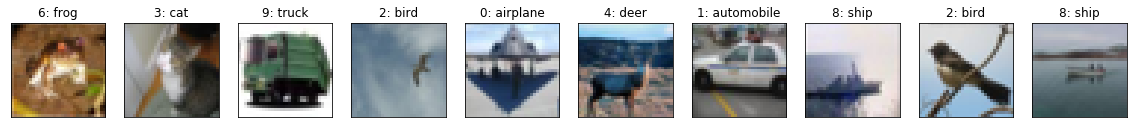

Original test dataset preview


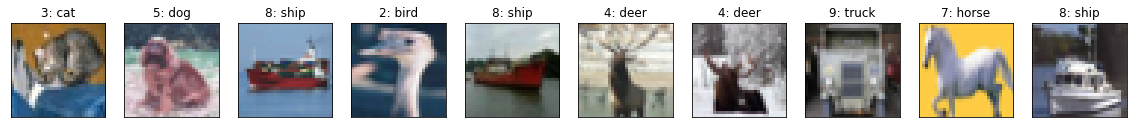

In [4]:
print('Original train dataset preview')
preview(original_train_data)
print('Original test dataset preview')
preview(original_test_data)

In [5]:
# Mean and std calculation
train_data = CIFAR10(root='data', train=True, download=False, transform=transforms.ToTensor())
train_loader = DataLoader(train_data, batch_size=200, shuffle=False, num_workers=2)

mean = []
std = []
for i, batch_data in enumerate(train_loader, 0):
    # shape (batch_size, 3, height, width)
    numpy_image = batch_data[0].numpy()
    
    # shape (3,)
    batch_mean = np.mean(numpy_image, axis=(0,2,3))
    batch_std = np.std(numpy_image, axis=(0,2,3))
    
    mean.append(batch_mean)
    std.append(batch_std)

# shape (num_iterations, 3) -> (mean across 0th axis) -> shape (3,)
mean = np.array(mean).mean(axis=0)
std = np.array(std).mean(axis=0)

print('mean =', mean, 'std =', std)

mean = [0.49139968 0.4821586  0.4465309 ] std = [0.2468175  0.24327388 0.2612973 ]


In [6]:
batch_size = 200

train_transf = transforms.Compose([
    #transforms.RandomResizedCrop(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
test_transf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

train_data = CIFAR10(root='data', train=True, download=False, transform=train_transf)
train_size = int(len(train_data) * 0.8)
valid_size = len(train_data) - train_size
train_data, valid_data = data.random_split(train_data, (train_size, valid_size))

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=2)

test_data = CIFAR10(root='data', train=False, download=False, transform=test_transf)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2)

In [7]:
def time_format(milliseconds):
    milliseconds = int(milliseconds)
    hours = int(milliseconds / (3600 * 1000))
    minutes = int((milliseconds % (3600 * 1000)) / (60 * 1000))
    seconds = int(((milliseconds % (3600 * 1000)) % (60 * 1000)) / 1000)
    milliseconds = int(((milliseconds % (3600 * 1000)) % (60 * 1000)) % 1000)
    
    return '%d:%02d:%02d.%d' % (hours, minutes, seconds, milliseconds)

In [8]:
def train_epoch(model, device, train_loader, optimizer, criterion, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        history_dict['loss'].append(loss.item())
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('  {:5}/{} ({:2.0f}%)\tLoss: {:.6f}'.
                  format(batch_idx * len(data),
                         len(train_loader.dataset),
                         100. * batch_idx / len(train_loader),
                         loss.item()))


def test(model, device, criterion, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = 100. * correct / len(test_loader.dataset)
    
    return accuracy

def train(model, optimizer, scheduler, criterion, train_loader, test_loader, device, lr, nb_epochs=3, log_interval=100):
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    
    start.record()
    
    for epoch in range(1, nb_epochs + 1):
        print('================================================================================')
        print('\nEpoch {}/{} - Training at LR {:.6}\n'.format(epoch, nb_epochs, scheduler.get_lr()[0]))
        
        train_epoch(model, device, train_loader, optimizer, criterion, log_interval)
        
        acc = test(model, device, criterion, valid_loader)
        
        print('\n  Validation accuracy: {:.2f}%\n'.format(acc))
        
        history_dict['val_acc'].append(acc)
        
        scheduler.step()
    
    end.record()
    
    torch.cuda.synchronize()
    
    print('================================================================================')
    print('\nElapsed time', time_format(start.elapsed_time(end)))
    
    return acc

def plot_curves(loss_values, val_acc):
    fig, ax = plt.subplots(2, 1, figsize=(15,5))
    ax[0].set_title('Training Loss')
    ax[0].plot(loss_values)
    ax[0].set_title('Loss')
    ax[0].set_xticks([])
    ax[1].set_title('Validation Accuracy')
    ax[1].plot(val_acc)
    ax[1].set_xticks([])

In [9]:
device = torch.device('cuda:0') #'cpu'
print('Batch size:', batch_size)
nb_epochs = 24
log_interval = 20
lr = 1e-2
step_size=8

Batch size: 200


In [10]:
model = models.resnet101(pretrained=True)

#print(model)

for name, module in model.named_children():
    if name in ['layer1', 'layer2', 'layer3']:
        for param in module.parameters():
            param.requires_grad = False

model.fc = nn.Linear(2048, 10, bias=True)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss().to(device)


Epoch 1/24 - Training at LR 0.01

      0/40000 ( 0%)	Loss: 2.451585
   4000/40000 (10%)	Loss: 1.760409
   8000/40000 (20%)	Loss: 1.571722
  12000/40000 (30%)	Loss: 1.787889
  16000/40000 (40%)	Loss: 1.655952
  20000/40000 (50%)	Loss: 1.661888
  24000/40000 (60%)	Loss: 1.512196
  28000/40000 (70%)	Loss: 1.696058
  32000/40000 (80%)	Loss: 1.491040
  36000/40000 (90%)	Loss: 2.168331

  Validation accuracy: 43.56%


Epoch 2/24 - Training at LR 0.01

      0/40000 ( 0%)	Loss: 1.622578
   4000/40000 (10%)	Loss: 1.528895
   8000/40000 (20%)	Loss: 1.367139
  12000/40000 (30%)	Loss: 1.365203
  16000/40000 (40%)	Loss: 1.545881
  20000/40000 (50%)	Loss: 1.381840
  24000/40000 (60%)	Loss: 1.245182
  28000/40000 (70%)	Loss: 1.115916
  32000/40000 (80%)	Loss: 1.341444
  36000/40000 (90%)	Loss: 1.305434

  Validation accuracy: 55.33%


Epoch 3/24 - Training at LR 0.01

      0/40000 ( 0%)	Loss: 1.119340
   4000/40000 (10%)	Loss: 1.211327
   8000/40000 (20%)	Loss: 0.981557
  12000/40000 (30%)	Loss: 

  12000/40000 (30%)	Loss: 0.051370
  16000/40000 (40%)	Loss: 0.056147
  20000/40000 (50%)	Loss: 0.034928
  24000/40000 (60%)	Loss: 0.060043
  28000/40000 (70%)	Loss: 0.043530
  32000/40000 (80%)	Loss: 0.033416
  36000/40000 (90%)	Loss: 0.027133

  Validation accuracy: 65.82%


Epoch 18/24 - Training at LR 0.001

      0/40000 ( 0%)	Loss: 0.031553
   4000/40000 (10%)	Loss: 0.035724
   8000/40000 (20%)	Loss: 0.045723
  12000/40000 (30%)	Loss: 0.064759
  16000/40000 (40%)	Loss: 0.027851
  20000/40000 (50%)	Loss: 0.051870
  24000/40000 (60%)	Loss: 0.057075
  28000/40000 (70%)	Loss: 0.046244
  32000/40000 (80%)	Loss: 0.057287
  36000/40000 (90%)	Loss: 0.038533

  Validation accuracy: 65.64%


Epoch 19/24 - Training at LR 0.001

      0/40000 ( 0%)	Loss: 0.026598
   4000/40000 (10%)	Loss: 0.024976
   8000/40000 (20%)	Loss: 0.046445
  12000/40000 (30%)	Loss: 0.054908
  16000/40000 (40%)	Loss: 0.064120
  20000/40000 (50%)	Loss: 0.024554
  24000/40000 (60%)	Loss: 0.045986
  28000/40000 (70%)	Lo

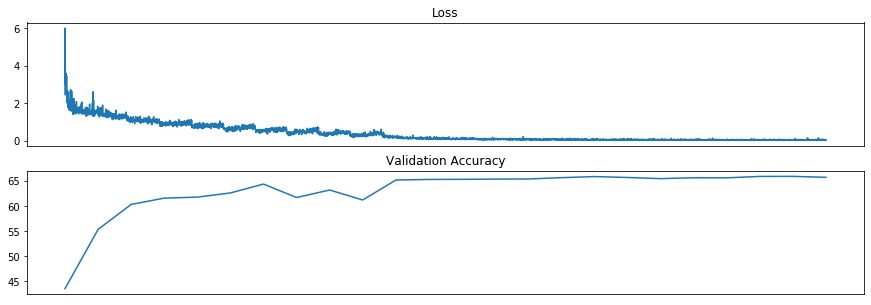

In [11]:
history_dict = defaultdict(list)
acc = train(model, optimizer, scheduler, criterion, train_loader, valid_loader, device, lr, nb_epochs, log_interval)
print('\nFinal accuracy: {:.2f}%'.format(acc))
plot_curves(history_dict['loss'], history_dict['val_acc'])

In [12]:
acc = test(model, device, criterion, test_loader)
        
print('\n  Test accuracy: {:.2f}%\n'.format(acc))


  Test accuracy: 66.15%

